In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import argparse
import json
import matplotlib.pyplot as plt
import numpy as np

from generator import Generator
from discriminator import Discriminator
from dataset import SatelliteDataset
from utils import save_example
import config
from datautils import create_img_from_classes, unprocess

In [2]:
device = "cpu"

In [3]:
ds = SatelliteDataset("../../data/train")
batch_size = 2
loader = DataLoader(ds, batch_size, shuffle=True)

In [4]:
rgb_a, rgb_ab, lc_a, lc_b, binary_mask, lc_ab, masked_areas = next(iter(loader))
rgb_a, rgb_ab, lc_a, lc_b, binary_mask = rgb_a.to(device), rgb_ab.to(device), lc_a.to(device), lc_b.to(device), binary_mask.to(device)
lc_ab = lc_ab.to(device)

In [5]:

rgb_a_unchanged_area = rgb_a.clone()

# look individually at changed area and do a pixel loss
# Not sure what type of loss is best,
# Maybe using some kind of local discriminator would be better, like in local and global inpainting paper
for j in range(len(masked_areas[0][0])):
    for i in range(len(masked_areas)):

        r_w = masked_areas[i][0][j]
        r_h = masked_areas[i][1][j]
        mask_size_w = masked_areas[i][2][j]
        mask_size_h = masked_areas[i][3][j]

        #r_w, r_h, mask_size_w, mask_size_h = masked_area
        # maybe not use the rgb_a is the classes are the same.
      #  local_gen_area = fake_img[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]
        rgb_ab_local_area = rgb_ab[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]


     #   fake_img_unchanged_area[j, :, r_w:r_w + mask_size_w, r_h:r_h + mask_size_h] = torch.zeros(3, mask_size_w, mask_size_h)
        rgb_a_unchanged_area[j, :, r_w:r_w + mask_size_w, r_h:r_h + mask_size_h] = torch.zeros(3, mask_size_w, mask_size_h)


In [6]:
index.shape

NameError: name 'index' is not defined

In [25]:
rgb_ab.shape

torch.Size([2, 3, 256, 256])

In [26]:
index = torch.stack(m_a)

NameError: name 'm_a' is not defined

In [27]:
m_a = [torch.vstack(ma) for ma in masked_areas]

In [28]:
torch.vstack(masked_areas[0])

tensor([[10, 98],
        [38, 57],
        [62, 35],
        [59, 42]])

In [29]:
masked_areas[0]

[tensor([10, 98]), tensor([38, 57]), tensor([62, 35]), tensor([59, 42])]

In [30]:
img = np.array(rgb_a_unchanged_area.cpu())[0]
img = np.moveaxis(img, 0, -1)

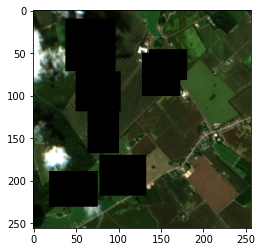

In [31]:
plt.imshow(img)

In [32]:
pixel_loss_fn = nn.MSELoss()

In [33]:
pixel_loss_fn(rgb_a_unchanged_area,rgb_a)

tensor(0.0126)

In [40]:
class StyleLoss(nn.Module):
    
    def __init__(self):
        super(StyleLoss, self).__init__()
        vgg_model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).to(device)
        self.relu3_3 = torch.nn.Sequential(*vgg_model.features[:16])
        
    def forward(self, img1, img2):
        phi1 = self.relu3_3(img1)
        phi2 = self.relu3_3(img2)

        batch_size, c, h, w = phi1.shape
        psi1 = phi1.reshape((batch_size, c, w*h))
        psi2 = phi2.reshape((batch_size, c, w*h))

        gram1 = torch.matmul(psi1, torch.transpose(psi1, 1, 2)) / (c*h*w)
        gram2 = torch.matmul(psi2, torch.transpose(psi2, 1, 2)) / (c*h*w)
        # as described in johnson et al.
        return torch.sum(torch.norm(gram1 - gram2, p = "fro", dim=(1,2))) / batch_size

In [41]:
def style_loss_fn2(phi1, phi2):
    phi1 = relu3_3(phi1)
    phi2 = relu3_3(phi2)
    
    batch_size, c, h, w = phi1.shape
    psi1 = phi1.reshape((batch_size, c, w*h))
    psi2 = phi2.reshape((batch_size, c, w*h))
    
    gram1 = torch.matmul(psi1, torch.transpose(psi1, 1, 2)) / (c*h*w)
    gram2 = torch.matmul(psi2, torch.transpose(psi2, 1, 2)) / (c*h*w)
    # as described in johnson et al.
    print(gram1.shape)
    return torch.sum(torch.norm(gram1 - gram2, p = "fro", dim=(1,2))) / batch_size


In [42]:
vgg_model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).to(device)
relu3_3 = torch.nn.Sequential(*vgg_model.features[:16])


Using cache found in C:\Users\hugih/.cache\torch\hub\pytorch_vision_v0.9.0


In [43]:
style_loss_fn = StyleLoss()

Using cache found in C:\Users\hugih/.cache\torch\hub\pytorch_vision_v0.9.0


In [44]:
style_loss_fn(rgb_a, rgb_a_unchanged_area)

tensor(0.2483, grad_fn=<DivBackward0>)

In [45]:
style_loss_fn2(rgb_a,rgb_a_unchanged_area)

torch.Size([2, 256, 256])


tensor(0.2483, grad_fn=<DivBackward0>)

In [15]:
lc_a.shape

torch.Size([2, 14, 256, 256])

In [16]:
lc1 = lc_a[0]
lc2 = lc_a[1]

In [17]:
classes = list(range(14))

In [18]:
lc1 = torch.argmax(lc1, dim=0)
lc2 = torch.argmax(lc2, dim=0)

In [19]:
len(lc1[(lc1 == 1) & (lc2 == 1)]) / len(lc1[(lc1 == 1) | (lc2 == 1)]) #(len(lc1[(lc1 == 1)]) + len(lc2[(lc2 == 1)]))

0.0

In [20]:
d = Discriminator()

In [21]:
d.load_state_dict(torch.load(f"results/results/models/discriminator.pt"))

RuntimeError: Error(s) in loading state_dict for Discriminator:
	Missing key(s) in state_dict: "bottleneck.block.0.weight", "bottleneck.block.0.bias", "bottleneck.block.1.weight", "bottleneck.block.1.bias", "bottleneck.block.1.running_mean", "bottleneck.block.1.running_var". 
	Unexpected key(s) in state_dict: "bottleneck1.block.0.weight", "bottleneck1.block.0.bias", "bottleneck1.block.1.weight", "bottleneck1.block.1.bias", "bottleneck1.block.1.running_mean", "bottleneck1.block.1.running_var", "bottleneck1.block.1.num_batches_tracked". 

In [ ]:
gen_a,_ = d(rgb_a)

In [ ]:
gen_a1 = gen_a[0]
gen_a2 = gen_a[1]

In [ ]:
gen_a1 = torch.argmax(gen_a1, dim=0)
gen_a2 = torch.argmax(gen_a2, dim=0)

In [ ]:
cla = 2

In [ ]:
len(((lc1 == cla) | (lc1 == cla))[(lc1 == cla) & (lc1 == cla)])

In [ ]:
lc1[(lc1 == cla) | (lc1 == cla)].shape[0]

In [ ]:
582 / 2

In [ ]:
lc_ac = torch.argmax(lc_a, dim=1)

In [ ]:
lc_ac.shape

In [ ]:
gen_ac = torch.argmax(gen_a, dim=1)

In [ ]:
lc_ac[:][(lc_ac[:] == 0) | (gen_ac[:] == 0)]

In [ ]:
def IoU(lc_a, lc_b, cla):
    union = lc_a[(lc_a == cla) | (lc_b == cla)].shape[0]
    if union == 0:
        return None
    return len(((lc_a == cla) | (lc_b == cla))[(lc_a == cla) & (lc_b == cla)]) / union

In [ ]:
def calc_single_IoUs(lc_a, lc_b):
    """
    Calculates the mean IoU,
    the weights of each class depend on their total ratio in lc_a
    """
    c_ratio = []
    ious = []
    for c in range(14):
        iou = IoU(lc_a, lc_b, c)
        n = lc_a.shape[0] * lc_a.shape[1]
        if iou != None:
            ious.append(iou)
            c_ratio.append(lc_a[lc_a==c].shape[0] / n)
    return np.sum(np.array(ious) * np.array(c_ratio))

In [22]:
def calc_all_IoUs(lc_a, lc_b):
    lc_a = torch.argmax(lc_a, dim=1)
    lc_b = torch.argmax(lc_b, dim=1)
    return np.mean([calc_single_IoUs(lc_a[i], lc_b[i]) for i in range(lc_a.shape[0])])

In [23]:
calc_all_IoUs(lc_a, gen_a)

NameError: name 'gen_a' is not defined

In [24]:
np.sum(c_ratio)

NameError: name 'c_ratio' is not defined

In [292]:
c_ratio

[0.008880615234375,
 0.528533935546875,
 0.0807342529296875,
 0.02239990234375,
 0.2718658447265625,
 0.02471923828125,
 0.03753662109375,
 0.02532958984375]

In [293]:
np.sum(np.array(ious) * np.array(c_ratio))

0.5302609868392726

In [294]:
np.mean(ious)

0.3093543055943993

<BarContainer object of 10 artists>

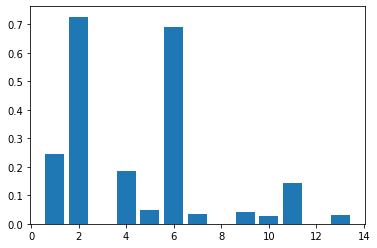

In [295]:
ious = []
cs = []
for c in range(14):
    iou = IoU(lc1, gen_a1, c)
    if iou:
        ious.append(iou)
        cs.append(c)
plt.bar(cs, ious)

In [296]:
ious

[0.24573378839590443,
 0.7268822336236725,
 0.1850632911392405,
 0.048159655831739964,
 0.6916967199038296,
 0.03526645768025078,
 0.04144775248102744,
 0.026519337016574586,
 0.14432989690721648,
 0.030466312846898675]

In [297]:
gi1 = create_img_from_classes(unprocess(gen_a.detach().numpy()))
i1 = create_img_from_classes(unprocess(lc_a.detach().numpy()))

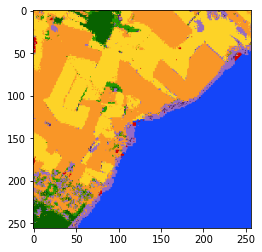

In [298]:
plt.imshow(i1)

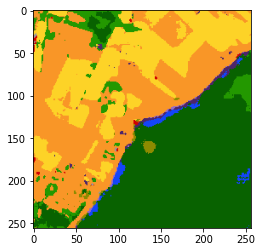

In [299]:
plt.imshow(gi1)

In [73]:
gi1

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [74]:
torch.argmax(gen_a, dim=1)

tensor([[[6, 6, 6,  ..., 2, 2, 2],
         [6, 6, 6,  ..., 2, 2, 2],
         [6, 6, 6,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 6, 2, 2],
         [2, 2, 2,  ..., 6, 6, 2],
         [2, 2, 2,  ..., 6, 6, 2]],

        [[4, 4, 4,  ..., 1, 6, 6],
         [4, 4, 4,  ..., 1, 6, 6],
         [4, 4, 2,  ..., 1, 6, 6],
         ...,
         [6, 6, 6,  ..., 5, 5, 5],
         [6, 6, 6,  ..., 5, 5, 5],
         [6, 6, 6,  ..., 5, 5, 5]]])